# Time Series Analysis

This notebook estimates autocorrelations and different time series models (AR, MA and VAR).

## Load Packages and Extra Functions


The [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) package has functions for calculating autocorrelations (and more), while the [OffsetArrays.jl](https://github.com/JuliaArrays/OffsetArrays.jl) package allows us to use non-standard indices of arrays, for instance, `x[0]`.

In [1]:
using Printf, DelimitedFiles, LinearAlgebra, Distributions, StatsBase, OffsetArrays

include("jlFiles/printmat.jl")
include("jlFiles/ARMAFilter.jl")
include("jlFiles/VARFilter.jl")
include("jlFiles/lagFn.jl")

lagFn

In [2]:
using Plots

#pyplot(size=(600,400))             #pyplot() or gr()
gr(size=(480,320))
default(fmt = :png)

## Load Data

In [3]:
xx  = readdlm("Data/RvSP500.csv",',',skipstart=1)
y   = xx[:,3]            #SP500 log realized monthly volatility
xx  = nothing

T   = size(y,1)
println("Sample size: $T")

Sample size: 574


# Descriptive Statistics

## Autocorrelations

The $s$th autocorrelation is the correlation of $y_{t}$ and $y_{t-s}$. It is a useful tool for describing the properties of data.

It can be shown that the t-stat of an autocorrelation is $\sqrt{T}$ times the autocorrelation. 

We can (jointly) test the first $L$ autocorrelations by the Box-Pierce test, which (under the null hypothesis of no autocorrelation) has a $\chi^2_L$ distribution.

In [4]:
L = 5
lags = 1:L
ρ = autocor(y,lags)         #using the StatsBase package

printblue("Autocorrelations:\n")
printmat([ρ sqrt(T)*ρ],colNames=["autocorrr","t-stat"],rowNames=lags,cell00="lag")

BP = T*sum(ρ.^2)

printblue("Box-Pierce test:\n")
printmat([BP,quantile(Chisq(L),0.9)],rowNames=["test statistic","10% critical value"])

Autocorrelations:

lag autocorrr    t-stat
1       0.709    16.982
2       0.602    14.419
3       0.529    12.684
4       0.459    11.000
5       0.455    10.903

Box-Pierce test:

test statistic       897.040
10% critical value     9.236



# White Noise

To estimate: traditional sample mean and standard deviation.

In [5]:
μ = mean(y)
σ = std(y)

printlnPs("Mean and std:",μ,σ)

Mean and std:     2.567     0.437


# AR(p)

This section discusses the properties and estimation of autoregressive (AR) processes.

## Impulse Response Function of AR Processes

The next cell shows how a shock to an AR process propagates over time (the "impulse response function"). This is a useful tool for understanding the properties of the model. 

The two models used here are an AR(1)

$
y_t = a y_{t-1} + \epsilon_t
$

and an AR(2)

$
y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.
$

For *stationary models*, the impulse response function eventually converges to zero. That is, the effect of a shock eventually disappears.

To be consistent with the lecture notes, the shock will happen in period 0, which will correspond to `ϵ[0]` below. To allow for vector indices that start at other values than 1, we use the [OffsetArrays.jl](https://github.com/JuliaArrays/OffsetArrays.jl) package. The next cell defines a function which helps setting up such arrays (the details of that are not important for the econometric application).

In [6]:
"""
    zerosX(ind)

Create a `zeros(ind)` array with indices `ind` (from OffsetArrays)

# Examples
- zerosX(-2:2) for a 5-element vector with indices -2:2
- zerosX((-2:2,1:2)) for a 5x2 matrix with row indices -2:2 and column indices 1:2

"""
function zerosX(ind)
    TN = isa(ind,UnitRange) ? length(ind) : length.(ind)  #a range or a tuple of ranges
    y = OffsetArray(zeros(TN),ind)
    return y
end

display(zerosX(-2:2))

5-element OffsetArray(::Vector{Float64}, -2:2) with eltype Float64 with indices -2:2:
 0.0
 0.0
 0.0
 0.0
 0.0

In [7]:
a = 0.85               #AR(1)
(a₁,a₂) = (0.85,-0.5)  #AR(2)

(t_min,t_max) = (-2,8)             #first period, last period
periods       = t_min:t_max

ϵ    = zerosX(periods)             #zeros, indices from t_min to t_max
ϵ[0] = 1                           #a shock in period 0, otherwise zeros

(y1,y2) = (copy(ϵ),copy(ϵ))
for t = 0:t_max
    y1[t] = a*y1[t-1] + ϵ[t]
    y2[t] = a₁*y2[t-1] + a₂*y2[t-2] + ϵ[t]  #or y2 = ARMAFilter(ϵ,[a₁,a₂])
end

printblue("The impulse responses to y1 (AR(1)) and y2 (AR(2)):\n")
printmat([y1 y2],colNames=["y1","y2"],rowNames=periods,cell00="period")

printred("However, we only plot period 0 and onwards")

The impulse responses to y1 (AR(1)) and y2 (AR(2)):

period        y1        y2
-2         0.000     0.000
-1         0.000     0.000
0          1.000     1.000
1          0.850     0.850
2          0.722     0.222
3          0.614    -0.236
4          0.522    -0.312
5          0.444    -0.147
6          0.377     0.031
7          0.321     0.100
8          0.272     0.069

However, we only plot period 0 and onwards


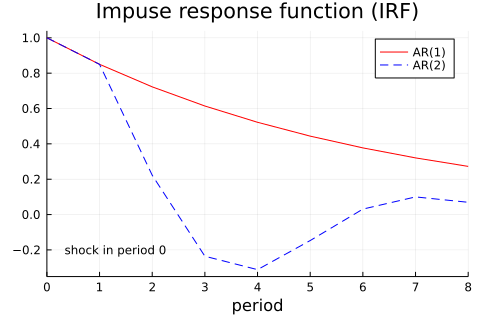

In [8]:
p1 = plot( periods,[y1 y2],                #[y1 y2] is a traditional array (needed for plot())
           label = ["AR(1)" "AR(2)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = periods,
           xlims = (0,8),                  #plot only period 0-
           xlabel = "period",
           title = "Impuse response function (IRF)",
           annotation = (1.3,-0.2,text("shock in period 0",8)) )
display(p1)

## The Roots of an AR Model (extra)

The *roots* of an AR(p) is a formal way of determining whether it is stationary. 

An easy way to calculate the roots is to first transform the AR(p) to a V(ector)AR(1) (also called companion form) and then calculate the eigenvalues. If their absolute values are lower than one, then the model is stationary.

For instance, an AR(2)

$
y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.
$

can be written as a 2-variable VAR(1) 

$
z_t = A_1 z_{t-1} + u_t,
$

where 

$z_t = 
\begin{bmatrix} 
y_t \\ 
y_{t-1}  
\end{bmatrix}$

and

$A_1 = 
\begin{bmatrix} 
a_1 & a_2\\ 
1 & 0 
\end{bmatrix}.$

In [9]:
"""
    Companion form of AR(p), that is, write AR(p) as a VAR(1)
"""
function CompanionFormAR(a)
    p = length(a)
    if p > 1                      #if order > 1
        A1 = vcat(a',[I  zeros(p-1)])
    else                          #if already VAR(1)
        A1 = copy(a)
    end
    return A1
end

CompanionFormAR

In [10]:
λ = eigen(CompanionFormAR([a₁,a₂])).values    #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.707
     0.707



## Estimation of an AR Process

AR models can be estimated by OLS.

The next cell defines a function for estimating an AR(p) model. It calls on `lagFn(y,s)` which is a convenience function for constructing a $Txn$ matrix with lag $s$ of $y$, padded with `NaN` at the top. 

In [11]:
function ARpEst(y,p)

    T    = length(y)
    
    xAll = fill(NaN,(T,p))  #build matrix of regressors
    for s = 1:p
        xAll[:,s] = lagFn(y,s)
    end
    xAll = [xAll ones(T)]              #add constant last
    #printmat([y xAll][1:10,:])        #uncomment to see the regressors

    b = xAll[p+1:end,:]\y[p+1:end]    #OLS, cut the first p observatioms 
    a = b[1:end-1]                     #slopes

    return a

end

ARpEst (generic function with 1 method)

In [12]:
aAR1 = ARpEst(y,1)
aAR2 = ARpEst(y,2)

printlnPs("Estimated AR(1) coef: ",aAR1)
printlnPs("Estimated AR(2) coefs: ",aAR2)

Estimated AR(1) coef:      0.713
Estimated AR(2) coefs:      0.569     0.204


# Forecasting with an AR Process

Forecasts can be calculated recursively. For instance, for an AR(2) and data on $(y_{-1},y_0$), we can calculate the forecast for $t=1$ as 

$
\textrm{E}_0 y_1 = a_1 y_0 + a_2 y_{-1}.
$

Then, the forecast for $t=2$ (still based on the information in $t=0$) is 

$
\textrm{E}_0 y_2 = a_1 \textrm{E}_0 y_1 + a_2 y_0,
$

where $\textrm{E}_0 y_1$ is from the first step.

The `zerosX(ind)` function (see above) is used to allow the vectors to have flexible indices (not starting at 1).

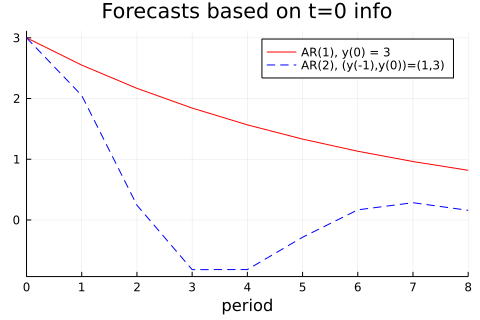

In [13]:
a = 0.85              #AR(1)

(a₁,a₂) = (0.85,-0.5)  #AR(2)

(t_min,t_max) = (-2,8)             #first period, last period
periods       = t_min:t_max

y1    = zerosX(periods)              #zeros, indices from t_min to t_max
y1[0] = 3
for t = 1:t_max                       #AR(1)
    y1[t] = a*y1[t-1]
end

y2        = zerosX(periods)
y2[-1:0] = [1,3]
for t = 1:t_max                       #AR(2)
    y2[t] = a₁*y2[t-1] + a₂*y2[t-2]
end

p1 = plot( [periods periods],[y1 y2],
           label = ["AR(1), y(0) = 3" "AR(2), (y(-1),y(0))=(1,3)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = periods,
           xlims = (0,8),            #plotting period 0 and onwards
           xlabel = "period",
           title = "Forecasts based on t=0 info" )
display(p1)

As an alternative, the `ARMAFilter(x,rho=[],theta=[],theta0=1.0,z0=[])` funtion can be used instead. Notice that it uses traditional (1-based) indexing of the arrays, but we can convert that using `OffsetArray(x,number of offsets)`.

In [14]:
_y2b = ARMAFilter(zeros(8),[a₁,a₂],[],1,[1,3])
y2b = OffsetArray([0;1;3;_y2b],-3)             #add initial values at indices -2,-1,0

printblue("We can also use the ARMAFilter() function to do the forecasts:\n")
printmat([y2 y2b],colNames=["loop","ARMAFilter()"],rowNames=-2:8,cell00="period",width=13)

We can also use the ARMAFilter() function to do the forecasts:

period         loop ARMAFilter()
-2            0.000        0.000
-1            1.000        1.000
0             3.000        3.000
1             2.050        2.050
2             0.242        0.242
3            -0.819       -0.819
4            -0.817       -0.817
5            -0.285       -0.285
6             0.166        0.166
7             0.284        0.284
8             0.158        0.158



## More Descriptive Statistics: Partial Autocorrelations

The partial autocorrelation coefficient is the regression coefficients on $x_{t-p}$ in an AR(p) regression, that is, on the last regressor. It is a useful tool for describing the properties of your data.

In [15]:
pac = pacf(y,lags)        #from the StatsBase package

printblue("autocorrelations and  partial autocorrelations:\n")
printmat([ρ pac],colNames=["autocorr","pac"],rowNames=lags,cell00="lag")

autocorrelations and  partial autocorrelations:

lag  autocorr       pac
1       0.709     0.713
2       0.602     0.204
3       0.529     0.103
4       0.459     0.031
5       0.455     0.130



# MA(q)

This section discusses the properties and estimation of moving average (MA) processes.

## Impulse Response Function of an MA(q) Process

goes to zero at lag q+1.

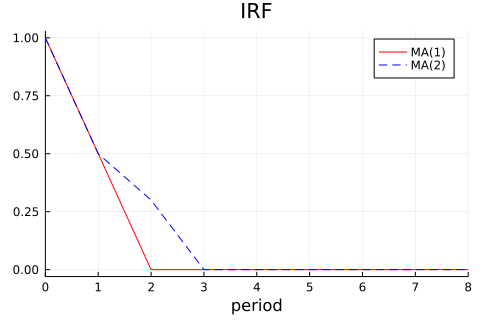

In [16]:
θ = 0.5              #MA(1)
(θ₁,θ₂) = (0.5,0.3)  #MA(2)

(t_min,t_max) = (-2,8)             #first period, last period
periods       = t_min:t_max

ϵ    = zerosX(periods)             #zeros, indices from t_min to t_max
ϵ[0] = 1                           #a shock in period 0, otherwise zeros 
(y1,y2) = (copy(ϵ),copy(ϵ))
for t = 0:t_max
    y1[t] = ϵ[t] + θ*ϵ[t-1]
    y2[t] = ϵ[t] + θ₁*ϵ[t-1] + θ₂*ϵ[t-2]   #or y2=ARMAFilter(ϵ,[],[θ₁,θ₂])
end

p1 = plot( periods,[y1 y2],
           label = ["MA(1)" "MA(2)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = periods,
           xlims = (0,8),        #period 0 and onwards
           xlabel = "period",
           title = "IRF" )
display(p1)

## Estimation of an MA(q) (extra)

To estimate an MA model, we can apply MLE. For the numerical optimization we use the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package. 

In [17]:
function MAqLL(par::Vector,y)
    (θ,σ) = (par[1:end-1],par[end])
    q     = length(θ)
    ϵ     = ARMAFilter(y,-θ)           #ϵ is AR(q) with coefs -θ
    LL_i  = -1/2*log(2*pi) .- 1/2*log(σ^2) .- 1/2*ϵ.^2/σ^2
    LL    = sum(LL_i)                  #sum(log-likelihood values)
    return LL, ϵ
end

MAqLL (generic function with 1 method)

In [18]:
using Optim

par0 = [0.5,0.3,0,0,1]   #θ₁,θ₂,θ₃,θ₄,σ         #estimate an MA(4)
Sol = optimize(par->-MAqLL(par,y)[1],par0)      #minimize -LL

θ = Optim.minimizer(Sol)[1:end-1]
σ = Optim.minimizer(Sol)[end]

printblue("MLE of MA(4):\n")
printmat([θ;σ],colNames=["parameters"],rowNames=["θ₁","θ₂","θ₃","θ₄","σ"],width=15)

MLE of MA(4):

       parameters
θ₁          1.458
θ₂          1.552
θ₃          1.170
θ₄          0.516
σ           0.638



In [19]:
λ = eigen(CompanionFormAR(-θ)).values    #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for MLE to be valid")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for MLE to be valid
     0.798
     0.798
     0.901
     0.901



# VAR(p)

This section discusses the properties and estimation of vector autoregressive (VAR) processes.

## Impulse Response Function of a VAR(1) Process

The cells below shows the impulse response function for a 2-variable VAR(1)

$
y_t = A_1 y_{t-1} + \epsilon_t
$,

where 

$y_t$ and $y_{t-1}$ are vectors with two elements and

$A_1 = 
\begin{bmatrix} 
0.5 & 0.2\\ 
0.1 & -0.3 
\end{bmatrix}.$

The code calls on the function `VARFilter()` (which was included at the top of the notebook). It uses traditional indexing (1-based) of arrays, but we can convert with `OffsetArray()`.

In [20]:
A1 = [0.5 0.2;
      0.1 -0.3]

(t_min,t_max) = (-2,8)
periods       = t_min:t_max

ϵ1    = [0 0;
         0 0;
         1 0;                                 #shock to variable 1 in period=0
         zeros(8,2)]
_IR_ϵ1 = VARFilter(ϵ1,A1,zeros(1,2))           #IR of both variables
IR_ϵ1  = OffsetArray(_IR_ϵ1,-3,0)

ϵ2    = [0 0;
         0 0;
         0 1;                                #shock to variable 2 in period=0
         zeros(8,2)]
_IR_ϵ2 = VARFilter(ϵ2,A1,zeros(1,2))           #IR of both variables 
IR_ϵ2  = OffsetArray(_IR_ϵ2,-3,0)

printblue("The impulse responses:\n")
printmat([IR_ϵ1 IR_ϵ2],colNames=["ϵ1->y1","ϵ1->y2","ϵ2->y1","ϵ2->y2"],rowNames=periods,cell00="period")

The impulse responses:

period    ϵ1->y1    ϵ1->y2    ϵ2->y1    ϵ2->y2
-2         0.000     0.000     0.000     0.000
-1         0.000     0.000     0.000     0.000
0          1.000     0.000     0.000     1.000
1          0.500     0.100     0.200    -0.300
2          0.270     0.020     0.040     0.110
3          0.139     0.021     0.042    -0.029
4          0.074     0.008     0.015     0.013
5          0.038     0.005     0.010    -0.002
6          0.020     0.002     0.005     0.002
7          0.011     0.001     0.003    -0.000
8          0.006     0.001     0.001     0.000



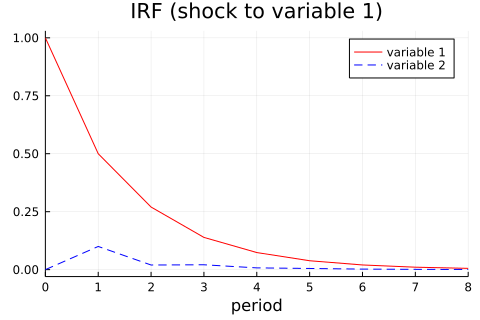

In [21]:
p1 = plot( periods,OffsetArrays.no_offset_view(IR_ϵ1),   #to traditional indices
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = periods,
           xlims = (0,8),       #period 0 and onwards
           xlabel = "period",
           title = "IRF (shock to variable 1)" )
display(p1)

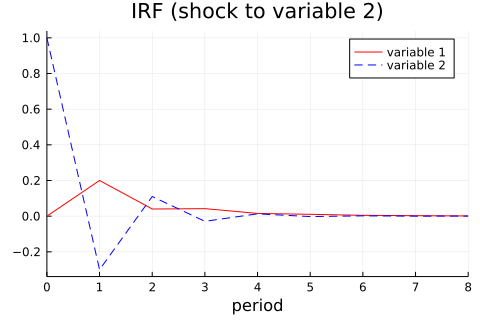

In [22]:
p1 = plot( periods,OffsetArrays.no_offset_view(IR_ϵ2),
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = periods,
           xlims = (0,8),
           xlabel = "period",
           title = "IRF (shock to variable 2)" )
display(p1)

## Forecasting with a VAR Process

The cell below shows that forecasting with a VAR is very similar to forecasting with an AR: a simple recursive approach works well. However, for simplicity we will again use the `VARFilter()` function.

In [23]:
periods = 0:8

y0 = [1 2]
_y2 = VARFilter(zeros(8,2),A1,y0)
y2  = OffsetArray([y0;_y2],-1,0)

printmat(y2,colNames=["y1","y2"],rowNames=periods,cell00="period")

period        y1        y2
0          1.000     2.000
1          0.900    -0.500
2          0.350     0.240
3          0.223    -0.037
4          0.104     0.033
5          0.059     0.000
6          0.029     0.006
7          0.016     0.001
8          0.008     0.001



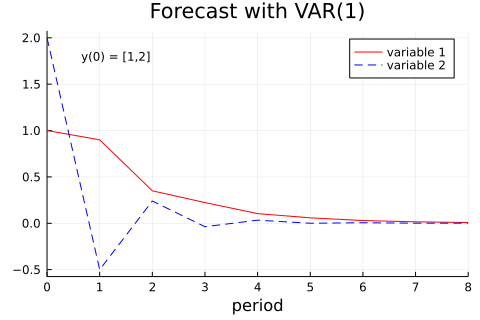

In [24]:
p1 = plot( periods,OffsetArrays.no_offset_view(y2),
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = periods,
           xlims = (0,8),
           xlabel = "period",
           title = "Forecast with VAR(1)",
           annotate=(1.3,1.8,text("y(0) = [1,2]",8)) )
display(p1)

# Non-Stationary Processes

The cells below shows the impulse response function and the roots of a non-stationary AR(3).

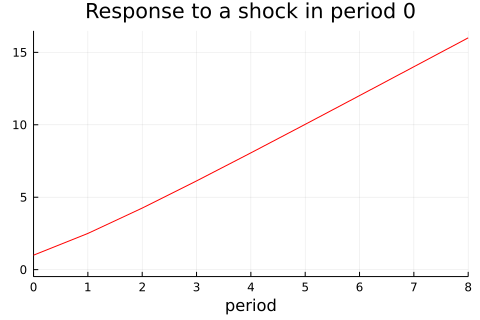

In [25]:
a = [2.5,-2,0.5]                      #AR(3) coefficients

periods = -3:8
ϵ = [0;0;0;1;zeros(8)]                #a shock in period 0, otherwise zeros

_y1 = ARMAFilter(ϵ,a)
y1  = OffsetArray(_y1,-4)

p1 = plot( periods,OffsetArrays.no_offset_view(y1),
           label = "",
           linecolor = :red,
           xticks = periods,
           xlims = (0,8),
           xlabel = "period",
           title = "Response to a shock in period 0" )
display(p1)

In [26]:
λ = eigen(CompanionFormAR(a)).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.500
     1.000
     1.000

